In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [55]:
# try:
#     tpu = tf.distribute.cluster_resolver.GPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.GPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math, re, os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# from tensorflow.keras
from tensorflow.keras.applications import VGG16
print("Tensorflow version " + tf.__version__)
import cv2


Tensorflow version 2.4.1


# Main Project related

Tensorflow version 2.4.1
(1, 150, 150, 3)


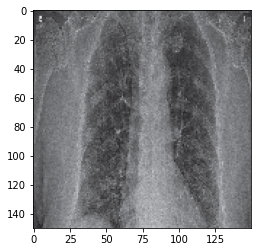

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math, re, os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
# from tensorflow.keras
from tensorflow.keras.applications import VGG16
print("Tensorflow version " + tf.__version__)
import cv2

img_path = '../input/recognizance/test/test1.jpg'

img = image.load_img(img_path, target_size = (150,150,))
img_tensor=image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /=255.

print(img_tensor.shape)
plt.imshow(img)

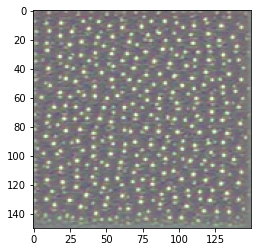

In [58]:
#Displaying learned features 

from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()
model = VGG16(weights= 'imagenet',
             include_top = False)

layer_name = 'block3_conv1'
filter_index = 0

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x



layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])



loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

input_img_data = np.random.random((1,150,150,3)) * 20+128

step = 1

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step
    
input_img_data.shape
plt.imshow(deprocess_image(input_img_data[0]))

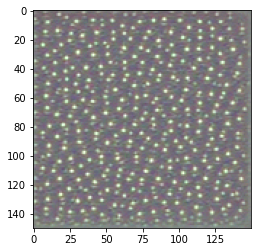

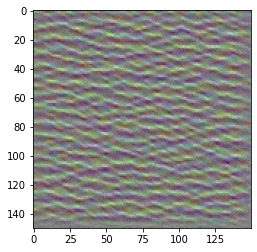

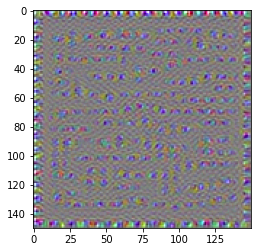

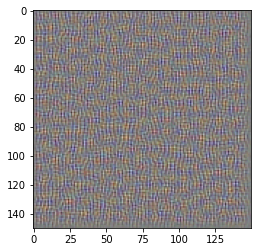

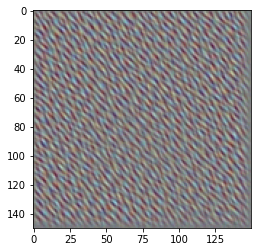

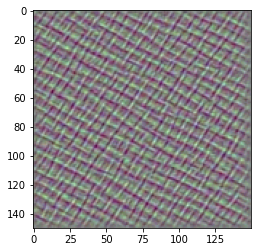

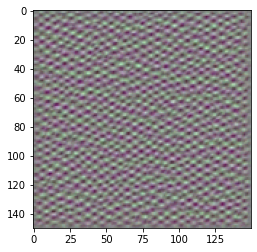

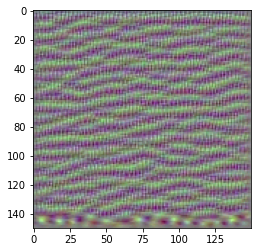

In [59]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size,size, 3))*20 + 128
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

# plt.figure()
for i in range(8):
    plt.figure()
    plt.imshow(generate_pattern('block3_conv1', i))
    
plt.show()


# Activation Heatmaps


In [60]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights = 'imagenet')


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '../input/recognizance/test/test1.jpg'
img = image.load_img(img_path, target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)


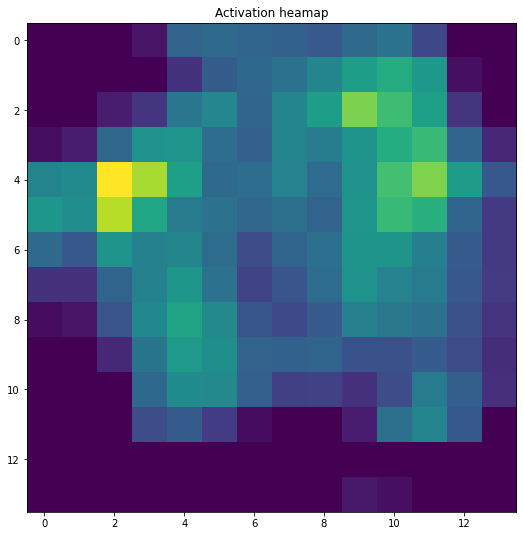

In [61]:
output_layer = model.output[:,885]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output_layer, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure(figsize = (14,9))
plt.title('Activation heamap')
plt.imshow(heatmap)

In [62]:
output_layer = model.output[:,885]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output_layer, last_conv_layer.output)[0]

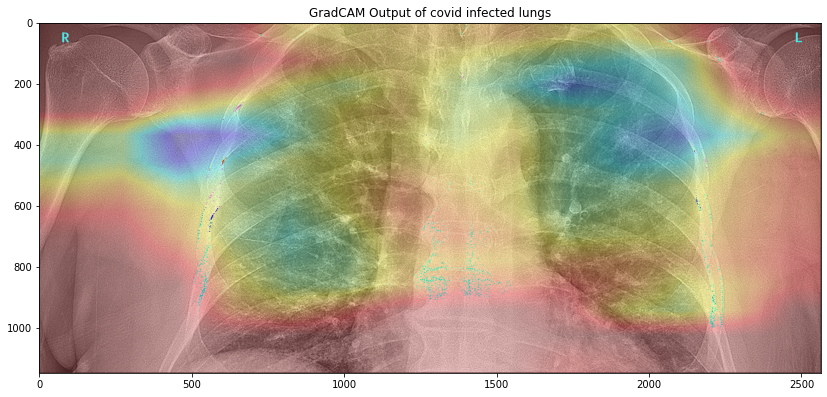

In [63]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.uint8(heatmap * 0.3)  + img
plt.figure(figsize = (14,9))
plt.title("GradCAM Output of covid infected lungs")
plt.imshow(superimposed_img)

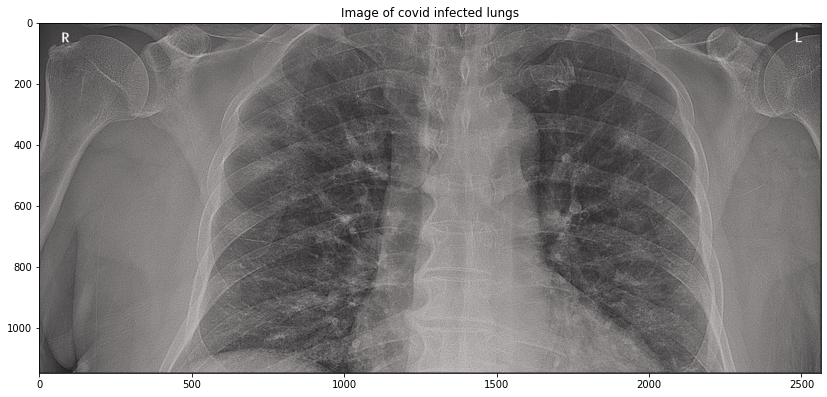

In [64]:
plt.figure(figsize = (14,9))
plt.title("Image of covid infected lungs")
plt.imshow(img)